### Install Ollama and Langchain

In [ ]:
# wandb gpu usage system matrices
#!pip install wandb
#import wandb
#wandb.init()

In [ ]:
#Install Ollama, a framework for serving and managing LLMs
!curl -fsSL https://ollama.com/install.sh | sh

#Install Python package that provides tools to interact with LLMs
!pip install langchain_community

!pip install langchain

### Start Ollama server as a background process and pull llama3 image.

In [ ]:
# Launches the Ollama server, which hosts and manages the LLMs locally
# This allows you to interact with the LLM in real-time
import subprocess
process = subprocess.Popen(["ollama", "serve"])

In [ ]:
#  Download the llama3 model from Ollama's repository
# !ollama pull llama3
#!ollama pull llama3.2
#!ollama pull gemma2:2b
#!ollama pull mistral
#!ollama pull qwen:4b
!ollama pull phi3:mini

In [ ]:
# Lists all the models currently available in Ollama
!ollama list

NAME         ID              SIZE      MODIFIED      
phi3:mini    4f2222927938    2.2 GB    2 seconds ago    


### Expose the port

In [ ]:
# Retrieve a proxy URL from Google Colab, which allows the notebook to communicate with the Ollama server running on a specific port (port 11434). The URL is set up to forward the server's responses.
from google.colab.output import eval_js
notebook_url = eval_js("google.colab.kernel.proxyPort(8000)")

In [ ]:
!export OLLAMA_HOST=notebook_url

RAG

In [ ]:
# Install required packages
!pip install langchain langsmith langchainhub langchain_chroma langchain_ollama beautifulsoup4 gpt4all langgraph langchain_core

# LangSmith Tracing

In [ ]:
import os

# Set environment variables for LangSmith
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# #os.environ["LANGCHAIN_PROJECT"] = ""
# os.environ["LANGCHAIN_API_KEY"] = ""

# Tools Use

In [ ]:
from langchain_chroma import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.document_loaders import RecursiveUrlLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from bs4 import BeautifulSoup
from langchain_text_splitters import HTMLHeaderTextSplitter

def extract_main_content(html):
    soup = BeautifulSoup(html, 'html.parser')
    main_div = soup.find('div', id='main')

    if main_div:
        # Convert the main div back to a string while preserving HTML structure
        return str(main_div)
    return ""

# Load document from the website with the custom extractor that focuses on the 'main' div
loader = RecursiveUrlLoader(
    "https://www.w3schools.com/dsa/",
    max_depth=2, #Takes 15min to load
    prevent_outside=True,
    base_url="https://www.w3schools.com/dsa",
    extractor=extract_main_content
)

# Load the documents
data = loader.load()

# Print the URLs from which the documents were loaded
if data:
    for i, doc in enumerate(data):
        print(f"Document {i+1} URL: {doc.metadata['source']}")
else:
    print("No content found in the specified 'main' div.")


#Process each document's page_content separately
def process_documents_separately(data):
    headers_to_split_on = [
        ("h1", "Header 1"),
        ("h2", "Header 2"),
        ("h3", "Header 3"),
    ]

    html_splitter = HTMLHeaderTextSplitter(headers_to_split_on)
    all_splits = []

    for doc in data:
        # Split the HTML content
        splits = html_splitter.split_text(doc.page_content)

        # Add the original document's source to each split
        for split in splits:
            split.metadata.update({
                "source": doc.metadata["source"]  # Preserve the original URL
            })

        all_splits.extend(splits)

    return all_splits

html_splits = process_documents_separately(data)


# Split the document into chunks
# all_splits = text_splitter.split_documents(data)

# Print the number of splits and the content of each split
print(f"Number of splits: {len(html_splits)}")

# Create embeddings and store the chunks in a vectorstore
local_embeddings = GPT4AllEmbeddings()

vectorstore = Chroma.from_documents(
    documents=html_splits,
    embedding=local_embeddings
)

# Retrieve based on a question
retriever = vectorstore.as_retriever(
    search_type="mmr",  # Use MMR for better diversity
    search_kwargs={
        "k": 5,  # Amount of documents to return
        "fetch_k": 10,  # Amount of documents to pass to MMR algorithm
        "lambda_mult": 0.5  # Diversity of results returned by MMR; 1 for minimum diversity and 0 for maximum.
    }
)

Document 1 URL: https://www.w3schools.com/dsa/
Document 2 URL: https://www.w3schools.com/dsa/dsa_theory_graphs_maxflow.php
Document 3 URL: https://www.w3schools.com/dsa/dsa_data_hashsets.php
Document 4 URL: https://www.w3schools.com/dsa/dsa_exam.php
Document 5 URL: https://www.w3schools.com/dsa/dsa_algo_insertionsort.php
Document 6 URL: https://www.w3schools.com/dsa/dsa_algo_linearsearch.php
Document 7 URL: https://www.w3schools.com/dsa/dsa_theory_mst_minspantree.php
Document 8 URL: https://www.w3schools.com/dsa/dsa_timecomplexity_linearsearch.php
Document 9 URL: https://www.w3schools.com/dsa/dsa_data_arrays.php
Document 10 URL: https://www.w3schools.com/dsa/dsa_data_queues.php
Document 11 URL: https://www.w3schools.com/dsa/dsa_data_hashmaps.php
Document 12 URL: https://www.w3schools.com/dsa/dsa_ref_huffman_coding.php
Document 13 URL: https://www.w3schools.com/dsa/dsa_algo_selectionsort.php
Document 14 URL: https://www.w3schools.com/dsa/index.php
Document 15 URL: https://www.w3schools.

Downloading: 100%|██████████| 45.9M/45.9M [00:00<00:00, 83.0MiB/s]
Verifying: 100%|██████████| 45.9M/45.9M [00:00<00:00, 554MiB/s]


# Document Grader Chain

In [ ]:
# Global variables to store the chains
retrieval_grader = None
history_aware_retriever = None
rag_chain = None
base_chain = None

In [ ]:
### Retrieval Grader

from langchain_core.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

def create_document_grader_chain(llm_model):
  # LLM
  llm = ChatOllama(model=llm_model, format="json", temperature=0)

  # Prompt
  prompt = PromptTemplate(
      template="""You are a grader assessing relevance of a retrieved document to a user question.

      1/ a QUESTION
      2/ A document (Fact)

      You are grading RELEVANCE RECALL:
      A score of 1 means that ANY of the statements in the document are relevant to the QUESTION.
      A score of 0 means that NONE of the statements in the document are relevant to the QUESTION.
      1 is the highest (best) score. 0 is the lowest score you can give.

      Explain your reasoning in a step-by-step manner to yourself, but your final output should be just the score.

      Return ONLY the binary score as a JSON object with a single key 'score', where the score is either 0 or 1.
      Example: {{"score": 1}}

      Question: {question}
      Document: {documents}

      Give the score as a number (0 or 1), as JSON.
      """,
      input_variables=["question", "documents"],
  )

  return prompt | llm | JsonOutputParser()



# Reformulate question with Chat History

In [ ]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def create_history_aware_chain(llm_model):
  llm = ChatOllama(model=llm_model, temperature=0)

  contextualize_q_system_prompt = """Given a chat history and the latest user question \
  which might reference context in the chat history, formulate a standalone question \
  which can be understood without the chat history. Do NOT answer the question, \
  just reformulate it if needed and otherwise return it as is."""

  contextualize_q_prompt = ChatPromptTemplate.from_messages(
      [
          ("system", contextualize_q_system_prompt),
          MessagesPlaceholder("chat_history"),
          ("human", "{input}"),
      ]
  )

  return create_history_aware_retriever(llm, retriever, contextualize_q_prompt)


# Generate Response with RAG

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

def create_RAG_chain(llm_model):

  llm = ChatOllama(model=llm_model, temperature=0)

  qa_system_prompt = """You are an assistant for question-answering tasks.
  First, check if the question is related to Data Structures and Algorithms (DSA).
  If the question is related to DSA, use the retrieved context to answer the student's question.
  If the question is not related to DSA, respond with "Please ask a question related to Data Structures and Algorithms (DSA)."
  After answering the student's question, follow up with a probing question to check the student's understanding.
  Keep the answer concise and ask the student a relevant follow-up question.

  {context}"""
  qa_prompt = ChatPromptTemplate.from_messages(
      [
          ("system", qa_system_prompt),
          MessagesPlaceholder("chat_history"),
          ("human", "{input}"),
      ]
  )


  question_answer_chain_RAG = create_stuff_documents_chain(llm, qa_prompt)

  return create_retrieval_chain(history_aware_retriever, question_answer_chain_RAG)

# Generate Response with Base LLM

In [ ]:
def create_baseLLM_chain(llm_model):

  llm = ChatOllama(model=llm_model, temperature=0)

  qa_system_prompt = """You are an assistant for question-answering tasks.
  First, check if the question is related to Data Structures and Algorithms (DSA).
  If the question is related to DSA, answer the student's question.
  If the question is not related to DSA, respond with "Please ask a question related to Data Structures and Algorithms (DSA)."
  If you don't know the answer, just say "I don't know."
  After answering the student's question, follow up with a probing question to check the student's understanding.
  Keep the answer concise and ask the student a relevant follow-up question.
  {context}
  """
  qa_prompt = ChatPromptTemplate.from_messages(
      [
          ("system", qa_system_prompt),
          MessagesPlaceholder("chat_history"),
          ("human", "{input}"),
      ]
  )


  question_answer_chain_base = create_stuff_documents_chain(llm, qa_prompt)

  return create_retrieval_chain(history_aware_retriever, question_answer_chain_base)

# Graph State

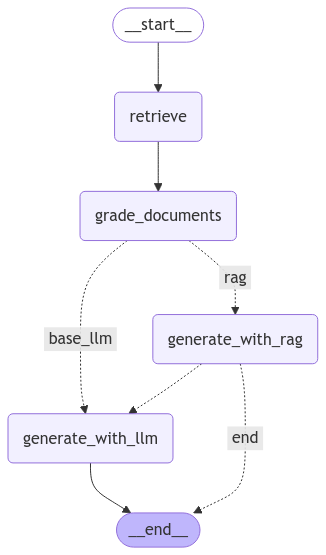

In [ ]:
from typing import List, Sequence
from typing_extensions import TypedDict, Annotated
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage

# Initialize base LLM
#base_llm = ChatOllama(model="llama3", temperature=0)

class GraphState(TypedDict):

    """Represents the state of our graph."""
    question: str
    generation: str
    search: str
    documents: List[str]
    chat_history: Annotated[Sequence[BaseMessage], add_messages]
    steps: List[str]

def retrieve(state):
    """Retrieve documents"""
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}

def grade_documents(state):
    """Grade documents and decide whether to use RAG or base LLM"""
    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []

    search = "Yes"  # Default to using base LLM

    for doc in documents:
        score = retrieval_grader.invoke({
            "question": question,
            "documents": doc.page_content
        })
        if score["score"] == 1:
            filtered_docs.append(doc)
            search = "No"  # Use RAG if we found relevant documents

    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }

def generate_with_rag(state):
    """Generate answer using RAG"""

    question = state["question"]
    documents = state["documents"]
    chat_history = state["chat_history"]
    steps = state["steps"]
    steps.append("generate_with_rag")

    response = rag_chain.invoke({"context": documents, "input": question, "chat_history": chat_history})

    return {
        "documents": documents,
        "question": question,
        "generation": response["answer"] + " [generated with RAG]",
        "chat_history": chat_history + [
            HumanMessage(state["question"]),
            AIMessage(response["answer"])
        ],
        "steps": steps,
    }


def generate_with_llm(state):
    """Generate answer using base LLM"""
    question = state["question"]
    chat_history = state["chat_history"]
    steps = state["steps"]
    steps.append("generate_with_llm")

    # Use base_chain instead of directly invoking LLM
    response = base_chain.invoke({
        "context": " ",
        "input": question,
        "chat_history": chat_history
    })

    return {
        "question": question,
        "generation": response["answer"] + " [generated with LLM]",
        "chat_history": chat_history + [
            HumanMessage(content=question),
            AIMessage(content=response["answer"])
        ],
        "steps": steps,
    }

#Conditional Edge
def decide_generation_method(state):
    """Decides whether to use RAG or base LLM"""
    search = state["search"]
    if search == "Yes":
        return "base_llm"
    else:
        return "rag"

def decide_fallback(state):
    """Decide whether to end or fallback to LLM based on RAG's output."""
    if "I don't know" in state["generation"]:
        return "generate_with_llm"
    else:
        return "end"

# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate_with_rag", generate_with_rag)  # generatae
workflow.add_node("generate_with_llm", generate_with_llm)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

# Add conditional edges based on document relevance
workflow.add_conditional_edges(
    "grade_documents",
    decide_generation_method,
    {
        "rag": "generate_with_rag",
        "base_llm": "generate_with_llm"
    }
)

# Add conditional edge after RAG to check if fallback to LLM is needed
workflow.add_conditional_edges(
    "generate_with_rag",
    decide_fallback,  # Use the new function to decide fallback
    {
        "generate_with_llm": "generate_with_llm",  # Fallback to LLM if needed
        "end": END  # End if RAG provides a valid answer
    }
)

# Add edges to END
workflow.add_edge("generate_with_llm", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
import uuid
from langchain_core.messages import HumanMessage

# Dictionary to manage chat histories for different sessions
chat_histories = {}

def predict_custom_agent_local_answer(example: dict, session_id: str):
    try:
        # Initialize chat history for this session if not already present
        if session_id not in chat_histories:
            chat_histories[session_id] = []

        # Retrieve the session-specific chat history
        chat_history = chat_histories[session_id]

        config = {"configurable": {"thread_id": str(uuid.uuid4())}}

        # Run the graph with the input
        state_dict = custom_graph.invoke(
            {"question": example["input"], "chat_history": chat_history, "steps": []},
            config,
        )

        # Update chat history for this session
        chat_histories[session_id] = state_dict["chat_history"]

        return {"response": state_dict["generation"]}

    except Exception as e:
        error_message = str(e)
        print(f"Error in predict_custom_agent_local_answer: {error_message}")
        return {"response": f"I apologize, but I encountered an error while processing your request. Please try again. {error_message}"}

In [ ]:
# example = {"input": "Explain to me a linked list"}
# response = predict_custom_agent_local_answer(example)
# response

# API EndPoint

In [ ]:
def create_graph_chains(llm):
  global retrieval_grader, history_aware_retriever, rag_chain, base_chain

  retrieval_grader = create_document_grader_chain(llm)
  history_aware_retriever = create_history_aware_chain(llm)
  rag_chain = create_RAG_chain(llm)
  base_chain = create_baseLLM_chain(llm)

  return retrieval_grader, history_aware_retriever, rag_chain, base_chain

In [ ]:
!pip install fastapi uvicorn nest_asyncio pyngrok

!ngrok config add-authtoken 

In [ ]:
from fastapi import FastAPI
import uvicorn
from pyngrok import ngrok
from pydantic import BaseModel
import nest_asyncio

# Apply nest_asyncio to allow the event loop to run
nest_asyncio.apply()

# Set up FastAPI
app = FastAPI()

# Create an ngrok tunnel on the default port
ngrok_tunnel = ngrok.connect(8000)
print("Public URL:", ngrok_tunnel.public_url)

class ChatRequest(BaseModel):
    session_id: str
    model: str
    message: str

# Function to dynamically select the model
def select_model(model_name: str):
    if model_name == "llama3":
        return ChatOllama(model="llama3")
    elif model_name == "gpt4all":
        return ChatOllama(model="gpt4all")
    else:
        raise ValueError(f"Unknown model: {model_name}")

@app.post("/chat")
async def chat_endpoint(data: ChatRequest):
    try:
        session_id = data.session_id
        model_name = data.model
        message = data.message

        if not session_id or not message or not model_name:
            return {"error": "Missing required fields: session_id, message, or model"}, 400

        # Dynamically create chains for the selected LLM
        create_graph_chains(model_name)

        # Call the prediction function
        response = predict_custom_agent_local_answer({"input": message}, session_id)

        return {"response": response["response"]}

    except Exception as e:
        return {"error": f"An error occurred: {str(e)}"}, 500

# Run the app using uvicorn
uvicorn.run(app, host="0.0.0.0", port=8000)


# Gradio UI

In [ ]:
# Install Gradio
# !pip install gradio

In [ ]:
# import gradio as gr

# # Wrap your function for Gradio
# def gradio_chatbot(message, history):
#     # Call your existing function to get the response
#     example = {"input": message}

#     # Call your custom agent function
#     result = predict_custom_agent_local_answer(example)

#     # Return the response
#     return result["response"]

# # Create the ChatInterface in Gradio
# gr.ChatInterface(gradio_chatbot).launch()

---
# Abstract
---
This project explores the use of Artificial Intelligence (AI) to improve upon traditional learning methods through the use of an AI-powered chatbot. Utilising natural learning processing (NLP) and machine learning algorithms, this project aims to develop a real-time, interactive learning tool for students, with the goal of helping them understand concepts, solve problems and clarify any doubts. The chatbot serves the purpose of preparing the students for Online Assessments and technical interviews for their Integrated Work Study Programme (IWSP). Additionally, the chatbot focuses on the topic of Data Structures and Algorithms (DSA), keeping students from going off-topic which further improves the learning experience.

---
# Methodology
---
This project was developed using the Ollama Large Language Model (LLM), which allows the chatbot to perform NLP tasks, enabling students to have a coherent and meaningful conversation regarding the topic of DSA.

## 1. Data Extraction for RAG
The `RecursiveUrlLoader` is used to scrape content from the W3Schools DSA section. This tool crawls the website recursively to a depth of two levels, ensuring that it gathers comprehensive content while staying within the designated domain.

The custom content extraction is handled by the extract_main_content function. This function parses the HTML structure of the webpage and isolates the specific content within the \<div> element that has the id="main". This division contains the main body of the article or tutorial that is relevant to the student's query.

## 2. Text Splitter - HTML Content Splitting
The function employs the `HTMLHeaderTextSplitter`, which breaks down the content at these headers, preserving the logical structure of the original text. By attaching metadata (such as the document's source URL) to each split section, the chatbot can reference specific sources during retrieval and generation, improving both accuracy and traceability of information.

##3. Vectorstore Retriever
The retriever is configured to retrieve relevant documents based on a user’s query using the Maximal Marginal Relevance (MMR) algorithm. MMR balances relevance and diversity by retrieving documents that are not only the most relevant but also diverse in content to avoid redundancy.

The parameters include:
* k=5: Specifies the number of documents to return to the user.
* fetch_k=10: Indicates the number of documents passed to the MMR algorithm before filtering for the most diverse results.
* lambda_mult=0.5: Controls the balance between relevance and diversity, with 0.5 providing a moderate balance.


##4. LangGraph

LangGraph is a framework used for managing workflows or complex decision-making processes in a structured, step-by-step manner. LangGraph allows for defining a graph-based representation of a workflow, where nodes represent tasks or functions (like retrieving documents or generating answers), and edges define the flow of execution based on conditions or outcomes.

* **Retrieve Documents**: This is the starting node where the system first attempts to gather relevant documents based on the user’s query.

* **Grade Documents**: After retrieval, this node evaluates the relevance of each document. This step is crucial in deciding whether to generate an answer using RAG or rely on the base LLM.

* **Generate with RAG**: If relevant documents are found, the system uses RAG to generate an answer by combining the user’s query with the retrieved context.

* **Generate with Base LLM**: If no relevant documents are found or RAG fails, the system falls back on the base LLM to generate an answer purely from the question and chat history

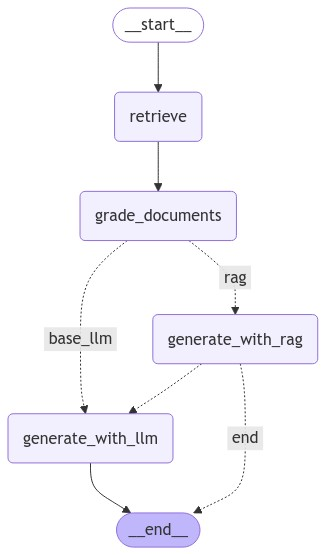

By using LangGraph, the entire process is managed efficiently, ensuring that each step is executed in the correct sequence while allowing conditional logic to control the flow.

###4a. Retrieve Documents
The Retrieve Documents node is the entry point in the LangGraph flow. When a user asks a question, this node initiates the process by querying the vector store

###4b. Grade Documents
Once the documents are retrieved, they are passed to the Grade Documents node. This node assesses the relevance of each document to the user’s query. The grading process ensures that irrelevant documents are filtered out, preventing noisy or irrelevant data from being used in the answer generation process.

The grading process is essential because, while retrieval captures documents based on keyword matches or contextual similarity, not all of these documents may be directly relevant to the user’s question. Grading helps filter out irrelevant or noisy documents, preventing them from being used in the response generation. This step ensures that only documents with a high degree of relevance are forwarded for use in the next node, improving the accuracy and quality of the chatbot’s response.

###4c. Generate with RAG
If the Grade Documents node finds that relevant documents are available, the flow moves to the Generate with RAG node. This node uses Retrieval-Augmented Generation (RAG) to generate an answer by combining the context from the retrieved documents with the user’s query. Additionally, the RAG prompt is configured to reject non-DSA-related questions. If a question is outside the scope of Data Structures and Algorithms, the chatbot will respond by asking the user to rephrase or ask a relevant DSA question. After providing an answer, the chatbot also follows up with a probing question to further engage the user and deepen their understanding of the topic.

###4d. Generate with Base LLM
If the Grade Documents node finds no relevant documents, or if the Generate with RAG node fails to produce a useful answer with the given RAG context, the flow proceeds to the Generate with LLM node. This node generates a response using the base language model without relying on document retrieval. Like the RAG prompt, the base LLM prompt is designed to reject non-DSA questions, ensuring that the chatbot remains focused on the relevant domain. After providing an answer, the chatbot follows up with a related question to test the user's comprehension and encourage further learning.


##5. Chat History

The chatbot utilizes LangChain’s `create_history_aware_retriever` to effectively manage and utilize the context of past conversations. This component is crucial in ensuring that student questions are understood in the context of prior interactions, allowing for more meaningful and coherent responses.

The retriever works by analyzing the chat history and the most recent user input, reformulating the input based on the conversation's context to create a standalone question that can be understood without needing the prior exchanges.

```
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""
```
Both the Retrieval-Augmented Generation (RAG) chain and the Base LLM
chain benefit from this approach. When the chatbot receives a user query, it first passes the question and the chat history through the history_aware_retriever. The retriever reformulates the question to make sure it is complete and meaningful in isolation. Once reformulated, this question can be fed into either:
*   **RAG Chain**: The reformulated question is used to retrieve relevant documents, which are then used to generate an answer.
*   **Base LLM Chain**: In cases where document retrieval isn’t necessary, the base chain processes the reformulated question directly to generate a response using the large language model.

##6. Graphical User Interface (GUI)

This chatbot uses Gradio to provide a simple interface to allow students to converse with it through a text-based input and output interface.

```
import gradio as gr

def gradio_chatbot(message, history):
    # Call your existing function to get the response
    example = {"input": message}

    # Call your custom agent function
    result = predict_custom_agent_local_answer(example)

    # Return the response
    return result["response"]

# Create the ChatInterface in Gradio
gr.ChatInterface(gradio_chatbot).launch()
```

---
# Results
---
**Redirecting off topic inputs:** When user entered with off-topic inputs, the chatbot effectively recognized them and replied the user to ask about DSA-related questions. This ensured the user to remained productive and educational. As shown on Figure 1, if a user types “What is your favourite song?” the chatbot recognizes the input as off-topic and responds with “Please ask DSA-related questions only.”

<u>Figure 1: Redirecting Off-Topics Inputs</u>

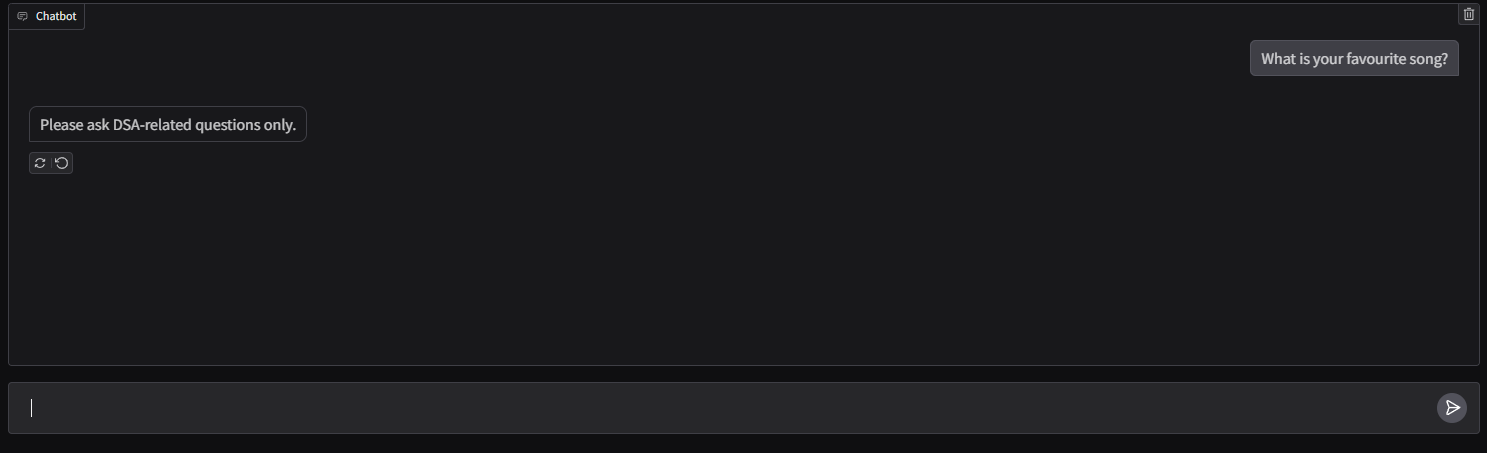


**Fallback on base LLM**: If the Retrieval-Augmented Generation (RAG) system is unable to generate a satisfactory answer, the chatbot seamlessly falls back to the base LLM.

<u>Figure 2:Fallback on base LLM if RAG fails</u>
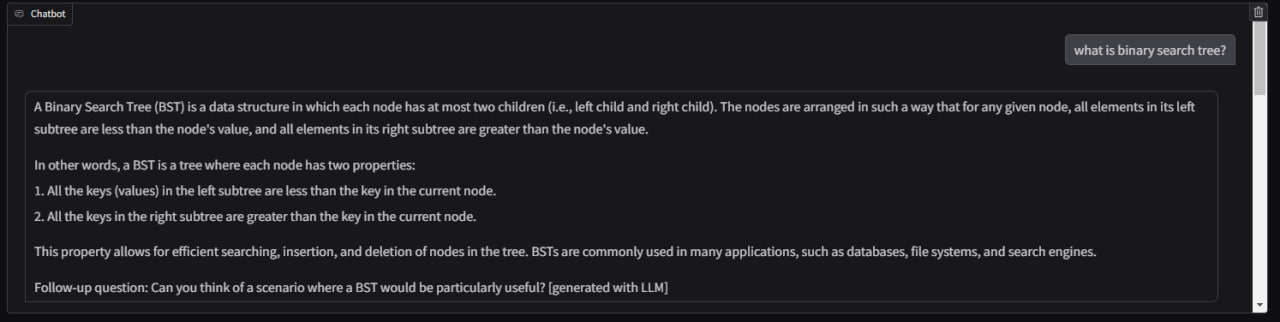

**Chat History**:
You can also say 'Can you explain more?' if you'd like to follow up on previous conversations, as there's chat history available." This shows that the chatbot retains context from earlier interactions.

<u> Figure 3: Chat History </u>
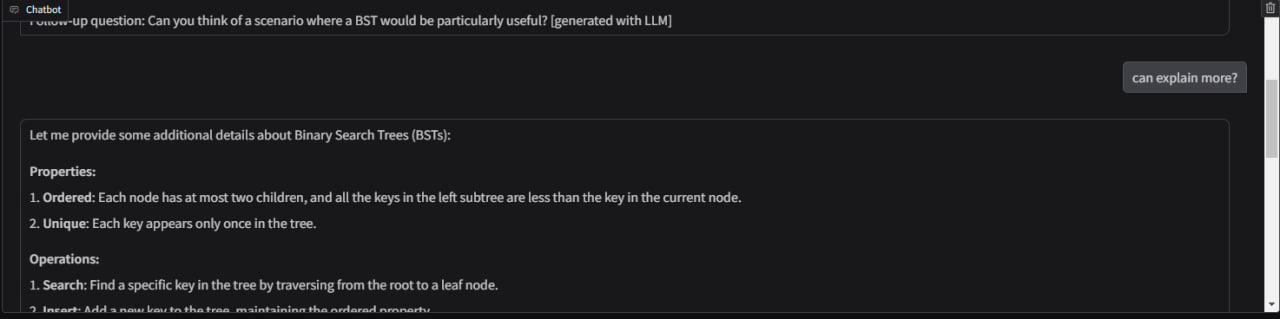


**Follow Up Questions**:
The chatbot effectively engages students by asking a follow-up question after providing an initial answer. This probing question encourages deeper reflection and understanding of the topic, promoting active learning. The approach enhances interactivity, simulating a dynamic learning experience similar to that of a tutor.

<u>Figure 4:Follow Up Question</u>
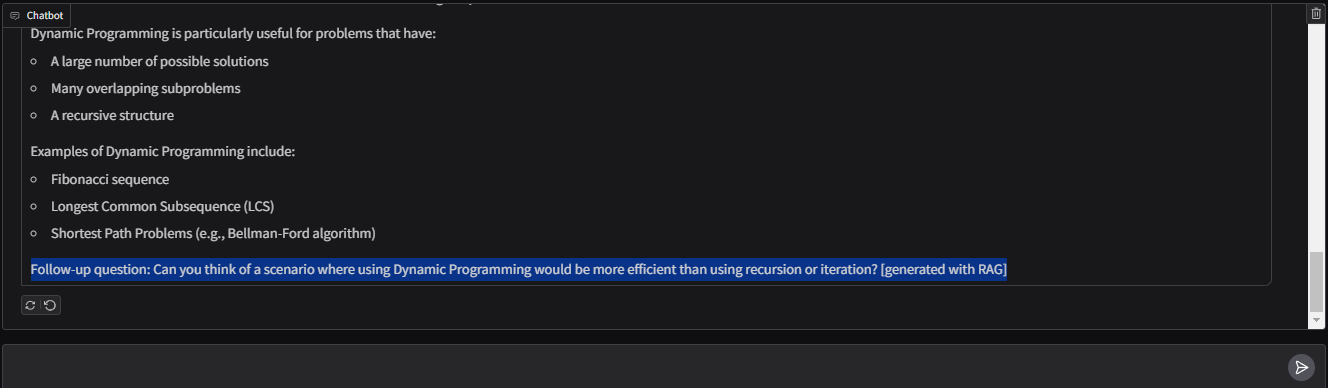

---
# Conclusion
---

The chatbot successfully implemented a dynamic and efficient chatbot system that integrates both Retrieval-Augmented Generation (RAG) and Large Language Models (LLMs) to handle queries related to data structure algorithms (DSA). It also employed a modular workflow design where each step—retrieval, grading, and response generation—was optimized for accuracy and relevance using cutting-edge techniques such as RecursiveUrlLoader for data extraction, HTMLHeaderTextSplitter for structured parsing, and Chroma for managing vector embeddings.

The use of Maximal Marginal Relevance (MMR) ensured a balance between relevance and diversity in retrieved documents, improving the quality of responses generated for user queries. The system also introduced flexibility by conditionally switching between RAG and LLM-based responses, depending on document relevance and the effectiveness of the initial retrieval.

This approach to integrating RAG with LLM provides a more reliable and contextually accurate system for answering complex queries, particularly in domains requiring deep semantic understanding like data structures and algorithms. Future work could extend the system to cover a broader range of topics and improve response times by further optimizing the retrieval and generation steps.